Installing required packages

In [ ]:
!python3 -m pip install tensorflow
!pip install scalecast --upgrade
!pip install holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.8 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.16-py3-none-any.whl size=116727 sha256=9cc14c8730dd015de3f30c97665fcd3c7f5409f952b7f108ce17a79c2a2888f9
  Stored in directory: /root/.cache/pip/wheels/c0/5b/59/3ddbe93f2054e783f032c768c8be0839b5efcfe2ab7ac1ced2
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=2bd45ff5d8baa6f106fdaeef399e8a0c189770f1501d9c3d9a3186070fbd902f
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e070070

##Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import plotly.express as px
import holidays
from scalecast.Forecaster import Forecaster
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split



##Data Preparation



> Traffic site ID



In [ ]:
traffic_siteId = 3223

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# File path for traffic site ID from generated csv

path = '/content/drive/MyDrive/MSc_Project_Traffic_Prediction/NZ Traffic Project/01- Data Landscape/NZ_data/'
file_path_siteID = path + f'artifacts/curated_data_siteID_{traffic_siteId}.csv'

In [ ]:
# Load dataset from a CSV file
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Data Preprocess


In [ ]:
# Load data from file_path
df = load_data(file_path_siteID)

# Drop unnecessary columns
columns_to_drop = ['siteID', 'regionName', 'SiteRef', 'siteRef', 'siteType', 'siteDescription', 'flowDirection', 'SH', 'geometry', 'startDate']
df_curated = df.drop(columns_to_drop, axis=1)

# Convert 'date' column to datetime
df_curated['date'] = pd.to_datetime(df_curated['date'])

# Set the index to the 'date' column
df_curated.index = df_curated['date']

# Drop duplicates
df_curated = df_curated.drop_duplicates()

# Reindex the DataFrame with daily frequency
df_curated = df_curated.asfreq('d')

In [ ]:
df_curated.head()

,date,week,month,year,holiday,trafficCount
date,,,,,,
2018-01-01,2018-01-01,Monday,1.0,2018.0,True,53353.0
2018-01-02,2018-01-02,Tuesday,1.0,2018.0,True,55222.0
2018-01-03,2018-01-03,Wednesday,1.0,2018.0,False,67560.0
2018-01-04,NaT,NaN,NaN,NaN,NaN,NaN
2018-01-05,NaT,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_weather = pd.DataFrame()
for year in range(2018, 2024):
  file_path_weather = path + f"weather/Auckland_NZ_weather_{year}.csv"
  df_weather = pd.concat([df_weather, load_data(file_path_weather)], axis=0)

In [ ]:
df_weather.datetime = pd.to_datetime(df_weather.datetime)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2046 entries, 0 to 219
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              2046 non-null   object        
 1   datetime          2046 non-null   datetime64[ns]
 2   tempmax           2046 non-null   float64       
 3   tempmin           2046 non-null   float64       
 4   temp              2046 non-null   float64       
 5   feelslikemax      2046 non-null   float64       
 6   feelslikemin      2046 non-null   float64       
 7   feelslike         2046 non-null   float64       
 8   dew               2046 non-null   float64       
 9   humidity          2046 non-null   float64       
 10  precip            2046 non-null   float64       
 11  precipprob        2046 non-null   int64         
 12  precipcover       2046 non-null   float64       
 13  preciptype        1506 non-null   object        
 14  snow              575 non

<ipython-input-11-34183b58c9b3>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_weather.datetime = pd.to_datetime(df_weather.datetime)


In [ ]:
df_weather.conditions.unique()

array(['Rain, Partially cloudy', 'Rain, Overcast', 'Clear',
       'Partially cloudy', 'Overcast', 'Rain'], dtype=object)

In [ ]:
conditions_categories = ['Rain, Partially cloudy', 'Rain, Overcast', 'Clear', 'Partially cloudy', 'Overcast', 'Rain']

# Convert 'conditions' column to categorical
df_weather['weather_conditions'] = pd.Categorical(df_weather['conditions'], categories=conditions_categories)

# Assign numerical categorical codes to the 'conditions' column
df_weather['weather'] = df_weather['weather_conditions'].cat.codes


In [ ]:
# Merge weather dataset

df_curated = df_curated.merge(df_weather[['datetime','tempmax','tempmin','temp', 'weather', 'humidity']],
                             left_on=df_curated.index,
                             right_on='datetime',
                             how='left')



In [ ]:
df_curated.index = df_curated['datetime']

In [ ]:
# Convert holidays and week days to categorical

nz_holidays = list(holidays.NewZealand(years = [2018,2019, 2020, 2021, 2022, 2023]).keys())

df_curated['week'] = df_curated.index.weekday
df_curated['month'] = df_curated.index.month
df_curated['year'] = df_curated.index.year
df_curated['holiday'] = df_curated.index.isin(nz_holidays)

df_curated = df_curated.drop(['date','datetime'],axis=1)

In [ ]:
df_curated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1946 entries, 2018-01-01 to 2023-04-30
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   week          1946 non-null   int64  
 1   month         1946 non-null   int64  
 2   year          1946 non-null   int64  
 3   holiday       1946 non-null   bool   
 4   trafficCount  1777 non-null   float64
 5   tempmax       1946 non-null   float64
 6   tempmin       1946 non-null   float64
 7   temp          1946 non-null   float64
 8   weather       1946 non-null   int8   
 9   humidity      1946 non-null   float64
dtypes: bool(1), float64(5), int64(3), int8(1)
memory usage: 140.6 KB


In [ ]:
# Order columns to set 'trafficCount' label at the end and features on left
df_curated = df_curated[['week', 'month', 'year', 'holiday', 'tempmax', 'tempmin', 'temp', 'weather', 'humidity', 'trafficCount']]

In [ ]:
df_curated.head()

,week,month,year,holiday,tempmax,tempmin,temp,weather,humidity,trafficCount
datetime,,,,,,,,,,
2018-01-01,0,1,2018,True,24.1,18.0,20.6,0,80.1,53353.0
2018-01-02,1,1,2018,True,23.0,21.0,21.9,1,89.6,55222.0
2018-01-03,2,1,2018,False,24.0,18.9,20.8,0,80.6,67560.0
2018-01-04,3,1,2018,False,22.0,14.0,18.6,0,70.5,NaN
2018-01-05,4,1,2018,False,20.0,16.0,17.6,0,87.0,NaN


In [ ]:
# Function to display missing values in dataset
def missing_val(text, df_curated):
    print(text)

    missing_values_count = df_curated.isna().sum()
    total_missing_values = missing_values_count.sum()

    # DataFrame to hold the missing value information
    missing_df = pd.DataFrame({
        "Column Name": missing_values_count.index,
        "Missing Values": missing_values_count.values
    })

    missing_df = missing_df.append({"Column Name": "\033[1mTotal missing values\033[0m", "Missing Values": total_missing_values}, ignore_index=True)
    table = tabulate(missing_df, headers='keys', tablefmt='grid', numalign='center')
    print(table)

# Calculate missing values for each column and pass the DataFrame to the function
missing_val("Before handling missing values", df_curated)


Before handling missing values
+----+----------------------+------------------+
|    | Column Name          |  Missing Values  |
+====+======================+==================+
| 0  | week                 |        0         |
+----+----------------------+------------------+
| 1  | month                |        0         |
+----+----------------------+------------------+
| 2  | year                 |        0         |
+----+----------------------+------------------+
| 3  | holiday              |        0         |
+----+----------------------+------------------+
| 4  | tempmax              |        0         |
+----+----------------------+------------------+
| 5  | tempmin              |        0         |
+----+----------------------+------------------+
| 6  | temp                 |        0         |
+----+----------------------+------------------+
| 7  | weather              |        0         |
+----+----------------------+------------------+
| 8  | humidity             |        0

<ipython-input-20-946b887f3ddd>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_df = missing_df.append({"Column Name": "\033Total missing values\033", "Missing Values": total_missing_values}, ignore_index=True)


In [ ]:
f = Forecaster(y=df_curated['trafficCount'],current_dates=df_curated.index)
f

Forecaster(
    DateStartActuals=2018-06-19T00:00:00.000000000
    DateEndActuals=2023-04-30T00:00:00.000000000
    Freq=D
    N_actuals=1777
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

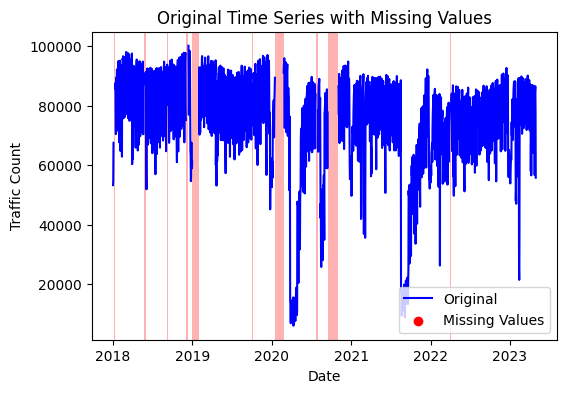

In [ ]:
# Perform seasonal decomposition
decomposition = f.seasonal_decompose()

# Plot the original time series with missing values highlighted
plt.figure(figsize=(6, 4))
plt.plot(df_curated.index, df_curated['trafficCount'], label='Original', color='blue')
plt.scatter(df_curated.index[df_curated['trafficCount'].isnull()], df_curated['trafficCount'][df_curated['trafficCount'].isnull()], color='red', label='Missing Values')
plt.title('Original Time Series with Missing Values')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.legend()

# Highlighted the gaps (missing values) with red lines
for idx, row in df_curated.iterrows():
    if pd.isnull(row['trafficCount']):
        plt.axvspan(idx - pd.DateOffset(days=0.5), idx + pd.DateOffset(days=0.5), facecolor='red', alpha=0.3)

plt.show()




###Handling missing values

In [ ]:
df_curated['trafficCount'] = df_curated['trafficCount'].interpolate(method='linear')




> Interpolation estimates missing values based on the neighboring data points.

Common interpolation methods include linear (method='linear'), polynomial (method='polynomial'), and spline (method='spline').


In [ ]:
df_curated.head()

,week,month,year,holiday,tempmax,tempmin,temp,weather,humidity,trafficCount
datetime,,,,,,,,,,
2018-01-01,0,1,2018,True,24.1,18.0,20.6,0,80.1,53353.000
2018-01-02,1,1,2018,True,23.0,21.0,21.9,1,89.6,55222.000
2018-01-03,2,1,2018,False,24.0,18.9,20.8,0,80.6,67560.000
2018-01-04,3,1,2018,False,22.0,14.0,18.6,0,70.5,69850.125
2018-01-05,4,1,2018,False,20.0,16.0,17.6,0,87.0,72140.250


In [ ]:
missing_val(" After handling missing values", df_curated)

 After handling missing values
+----+----------------------+------------------+
|    | Column Name          |  Missing Values  |
+====+======================+==================+
| 0  | week                 |        0         |
+----+----------------------+------------------+
| 1  | month                |        0         |
+----+----------------------+------------------+
| 2  | year                 |        0         |
+----+----------------------+------------------+
| 3  | holiday              |        0         |
+----+----------------------+------------------+
| 4  | tempmax              |        0         |
+----+----------------------+------------------+
| 5  | tempmin              |        0         |
+----+----------------------+------------------+
| 6  | temp                 |        0         |
+----+----------------------+------------------+
| 7  | weather              |        0         |
+----+----------------------+------------------+
| 8  | humidity             |        0

<ipython-input-20-946b887f3ddd>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  missing_df = missing_df.append({"Column Name": "\033Total missing values\033", "Missing Values": total_missing_values}, ignore_index=True)


In [ ]:
df_curated.describe()

,week,month,year,tempmax,tempmin,temp,weather,humidity,trafficCount
count,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,3.000000,6.275437,2020.184995,19.632477,13.079445,16.198356,1.144399,79.757400,76737.142343
std,2.000514,3.490005,1.548430,3.830770,3.895558,3.606337,1.559517,7.702088,17077.511130
min,0.000000,1.000000,2018.000000,11.000000,2.000000,7.000000,0.000000,55.800000,6065.000000
25%,1.000000,3.000000,2019.000000,16.200000,10.100000,13.300000,0.000000,74.600000,70658.250000
50%,3.000000,6.000000,2020.000000,19.500000,13.000000,16.300000,0.000000,79.900000,81718.000000
75%,5.000000,9.000000,2021.000000,22.900000,16.000000,19.200000,3.000000,85.300000,87760.750000
max,6.000000,12.000000,2023.000000,29.000000,23.900000,24.800000,5.000000,97.600000,100219.000000


#Visualize

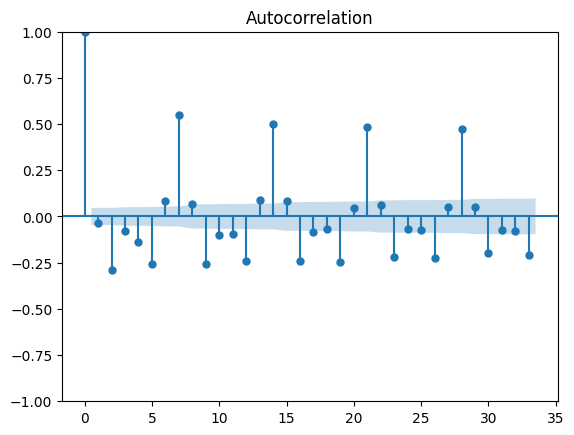

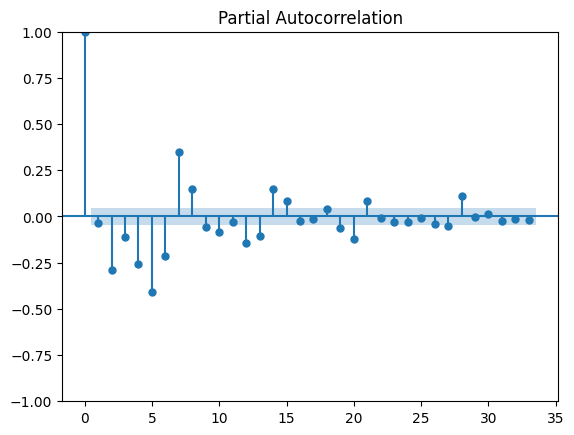

In [ ]:
f.plot_acf(diffy=True)
f.plot_pacf(diffy=True)
plt.show()



---

From this plot, it looks like a statistically significant correlation may exist up to about 14 time lags. The periodic spikes at 7, 14, and 21 lags suggest there are meaningful cyclical patterns in the data at weekly intervals.


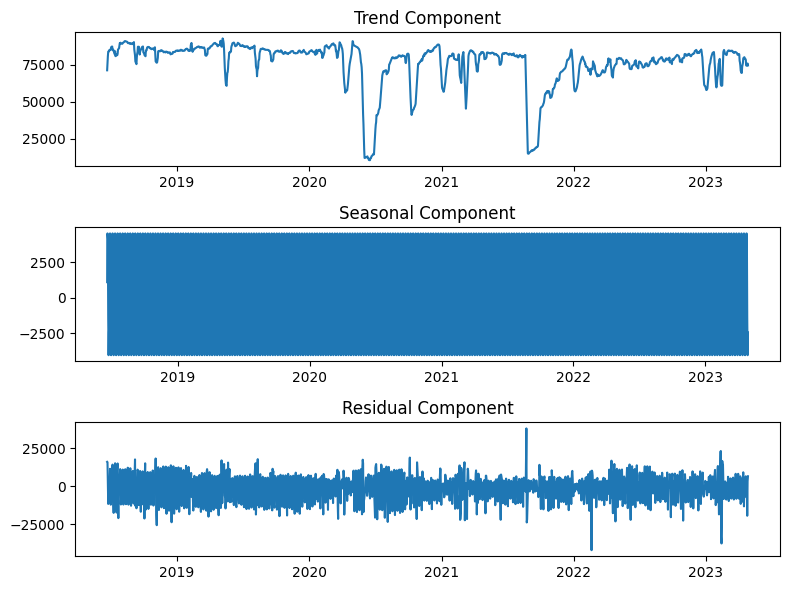

In [ ]:
# Plot the trend, seasonal, and residual components
plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend)
plt.title('Trend Component')

plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal)
plt.title('Seasonal Component')

plt.subplot(3, 1, 3)
plt.plot(decomposition.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()

---

The plot displays a decomposition of the traffic time series into a trend, seasonal pattern, and residual noise. The trend indicates a gradual decline in traffic volumes. The residual fluctuates around zero representing the random noise and unexplained variation.


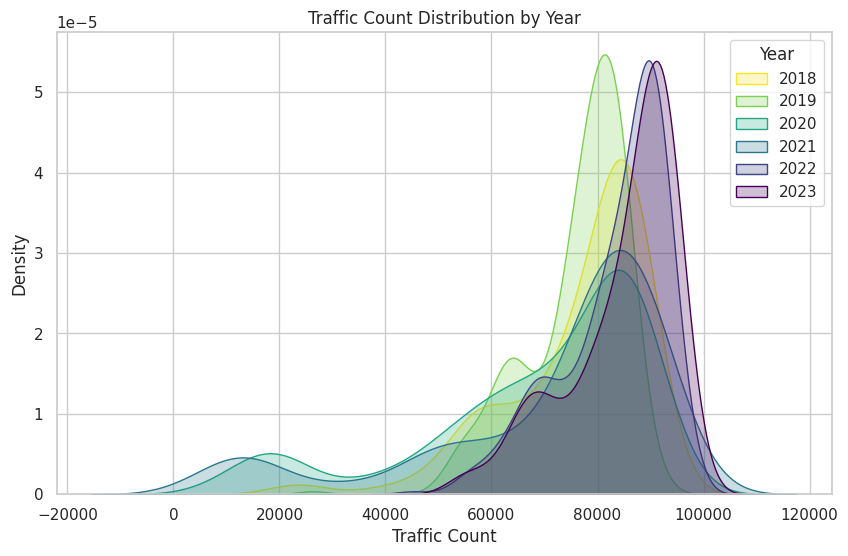

In [ ]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a density plot to compare traffic count distribution for different years
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_curated, x='trafficCount', hue='year', common_norm=False, fill=True, palette='viridis')

plt.title('Traffic Count Distribution by Year')
plt.xlabel('Traffic Count')
plt.ylabel('Density')
plt.legend(title='Year', loc='upper right', labels=[str(year) for year in df_curated['year'].unique()])

plt.show()


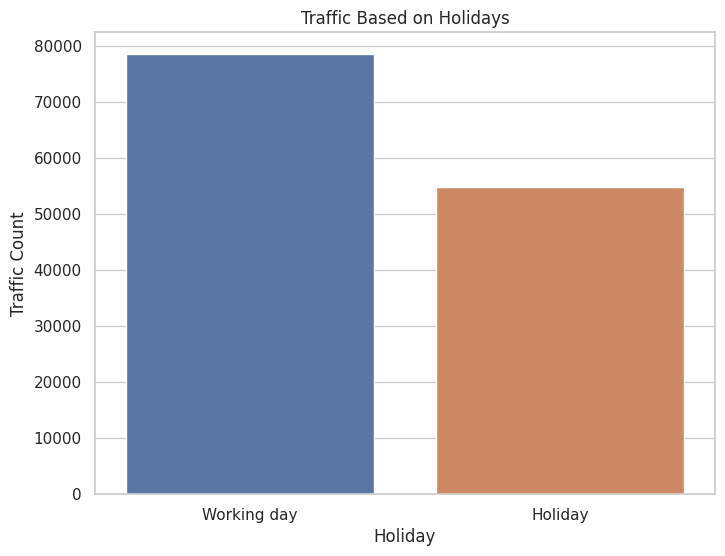

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x="holiday", y="trafficCount", data=df, errorbar=None)
plt.title("Traffic Based on Holidays")
plt.xlabel("Holiday")
plt.ylabel("Traffic Count")
plt.xticks([0, 1], ["Working day", "Holiday"])

plt.show()


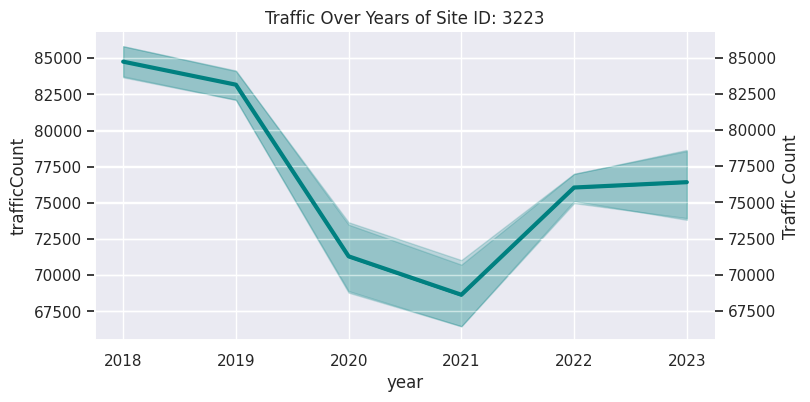

In [ ]:
plt.figure(figsize=(8, 4))
sns.set_style('darkgrid')
ax = sns.lineplot(x="year", y="trafficCount", data=df_curated, color='teal')
ax2 = ax.twinx()
sns.lineplot(x="year", y="trafficCount", data=df_curated, linewidth=3, color='teal')
plt.title(f"Traffic Over Years of Site ID: {traffic_siteId}")
plt.xlabel("Year")
plt.ylabel("Traffic Count")

sns.despine()
plt.xticks(size=12)

plt.show()


In [ ]:
# Created separate DF for visualization
df_curated_viz = df_curated.copy()

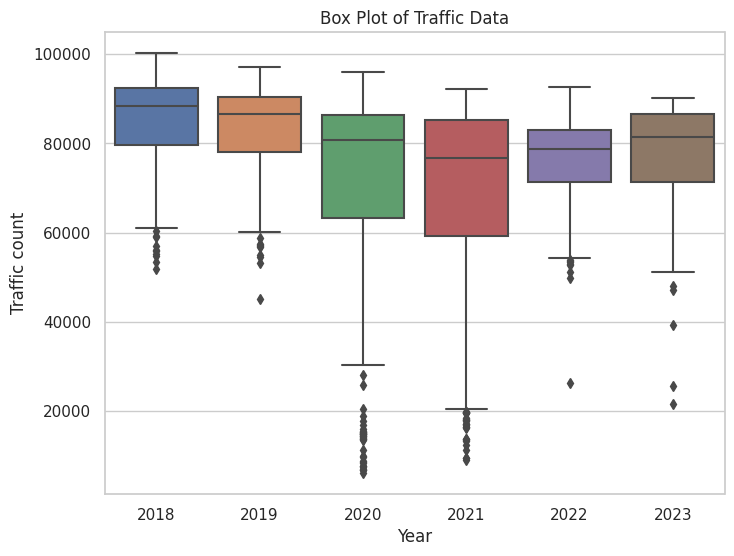

In [ ]:
sns.set(style="whitegrid")

# Created a box plot to visualize outliers in the 'trafficCount' column
plt.figure(figsize=(8, 6))
sns.boxplot(x='year', y='trafficCount', data=df_curated_viz)
plt.title("Box Plot of Traffic Data")
plt.xlabel("Year")
plt.ylabel("Traffic count")
plt.show()


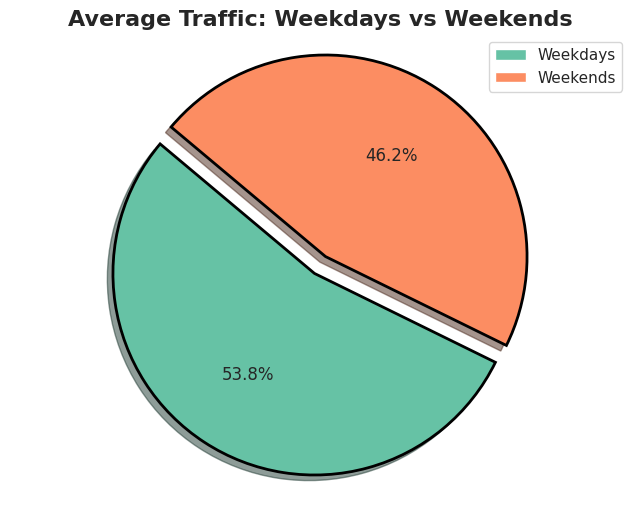

In [ ]:
# Calculate day type (Weekday or Weekend) based on the 'week' column
df_curated_viz['day_type'] = df_curated['week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average traffic counts for weekdays and weekends
average_weekdays = df_curated_viz[df_curated_viz['day_type'] == 'Weekday']['trafficCount'].mean()
average_weekends = df_curated[df_curated_viz['day_type'] == 'Weekend']['trafficCount'].mean()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a 2D pie chart
explode = (0.1, 0)  # Explode the first slice
colors = ['blue', 'orange']
wedges, texts, autotexts = plt.pie([average_weekdays, average_weekends], explode=explode, labels=None,
                                    colors=sns.color_palette("Set2"), autopct='%1.1f%%', startangle=140, shadow=True)

# Add custom labels inside the pie chart
labels = ['Weekdays', 'Weekends']
plt.legend(wedges, labels, loc="best")


# Add shadow effect to create 3D illusion
for w in wedges:
    w.set_linewidth(2)
    w.set_edgecolor('gray')

# Add border to the pie chart wedges
for w in wedges:
    w.set_linewidth(2)
    w.set_edgecolor('black')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.title("Average Traffic: Weekdays vs Weekends", fontsize=16, fontweight='bold')


plt.show()


<ipython-input-204-7d094cc040e0>:19: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.

<ipython-input-204-7d094cc040e0>:20: MatplotlibDeprecationWarning:

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.



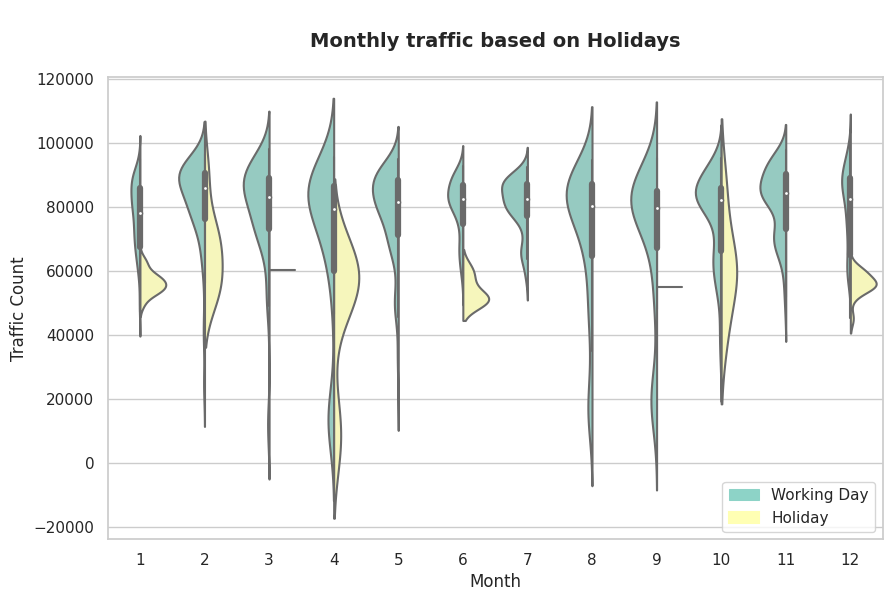

In [ ]:
# Calculate the percentage of holidays in each month
df_curated_viz['is_holiday'] = df_curated_viz['holiday'].astype(int)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

custom_palette = sns.color_palette("Set3")

# Create the violin plot
ax = sns.violinplot(x="month", y="trafficCount", hue="is_holiday", data=df_curated_viz, split=True, palette=custom_palette)

# Annotate the plot
plt.title("\nMonthly traffic based on Holidays\n", fontsize=14, fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Traffic Count")

# Set the legend outside the plot
ax.legend(labels=["Working Day", "Holiday"], loc='lower right')
ax.get_legend().legendHandles[0].set_color(custom_palette[0])
ax.get_legend().legendHandles[1].set_color(custom_palette[1])

plt.show()


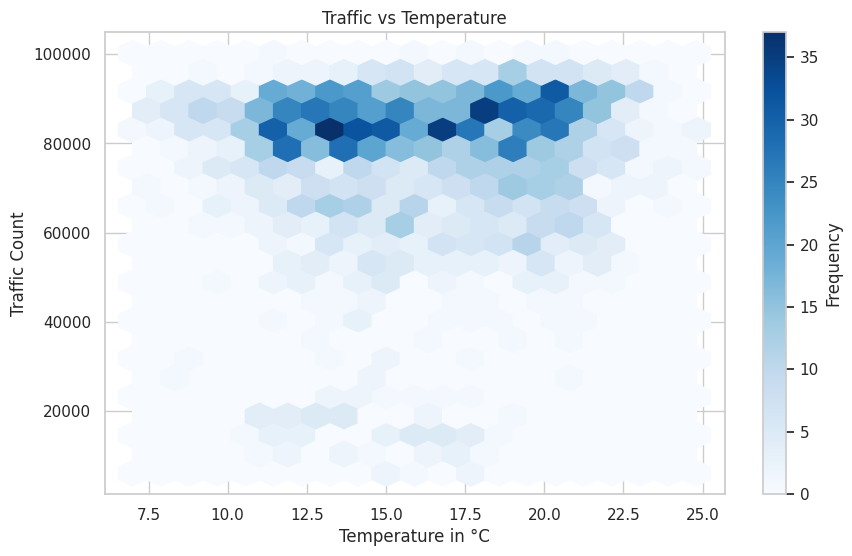

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a hexbin plot
hb = plt.hexbin(x=df_curated_viz['temp'], y=df_curated_viz['trafficCount'], gridsize=20, cmap='Blues')

# Annotate the plot
plt.title("Traffic vs Temperature")
plt.xlabel("Temperature in °C")
plt.ylabel("Traffic Count")

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label("Frequency")

plt.show()


In [ ]:
years = df_curated_viz['year'].unique()
color_map = {year: f'rgb({r},{g},{b})' for year, r, g, b in zip(years, *[range(0, 255, 255//len(years))] * 3)}

# Scatterplot temp vs traffic
fig = px.scatter(df_curated_viz, x='temp', y='trafficCount', facet_col='is_holiday',
                 color='year', color_discrete_map=color_map)

fig.layout['yaxis1'].update(title='Traffic Count')

# Update both x-axis titles
fig.layout['xaxis1'].update(title='Temperature in °C')
fig.layout['xaxis2'].update(title='Temperature in °C')

# Update facet labels
fig.layout.annotations[0].update(text='Holiday')
fig.layout.annotations[1].update(text='Work Day')


fig.update_layout(
    title={
        'text': '<b>\nTraffic by temperature on Holidays and Working days\n\n</b>',
        'font': {'size': 20, 'color': 'black'},
        'x':0.5,
        'xanchor': 'center'
    })

# Display graphs
fig.show()


In [ ]:
df_filtered = df_curated[(df_curated['weather'] == 0) | (df_curated['weather'] == 4)]

# Aggregate mean traffic by year and weather
df_yearly = df_filtered.groupby(['year', 'weather'])['trafficCount'].mean().reset_index()

df_yearly_filtered = df_yearly[df_yearly['year'] < 2023]

# Plot line chart with data points for filtered data
fig = px.line(df_yearly_filtered, x='year', y='trafficCount', color='weather', markers=True)

# Customize labels
fig.for_each_trace(lambda t: t.update(name='Clear') if t.name == '0' else t.update(name='Rainy'))

fig.update_layout(title='Traffic in Rain',
                  xaxis_title='Year',
                  yaxis_title='Traffic Volume',
                  xaxis=dict(
                      tickmode='array',  # Set tick mode to 'array'
                      tickvals=df_yearly_filtered['year'],  # Specify tick values as years
                      ticktext=df_yearly_filtered['year'].astype(str),  # Convert years to strings
                  ))

fig.show()









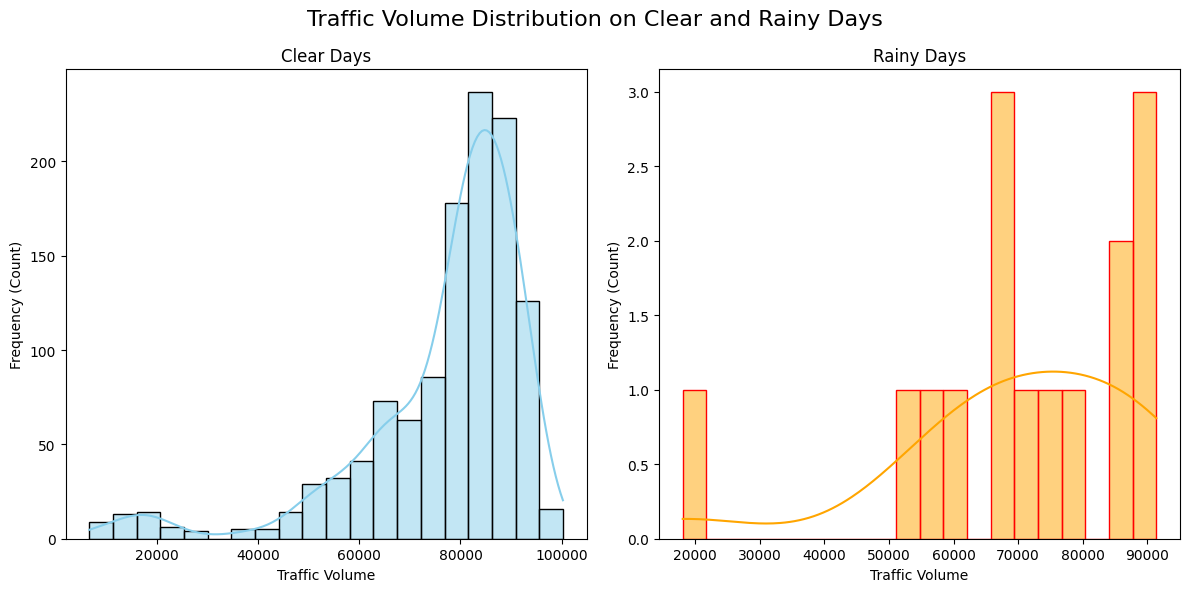

In [ ]:
# Filter data by weather
df_clear = df_curated[df_curated['weather'] == 0]
df_rain = df_curated[df_curated['weather'] == 4]

# Set up the figure and subplots
plt.figure(figsize=(12, 6))
plt.suptitle('Traffic Volume Distribution on Clear and Rainy Days', fontsize=16)

# Plot histogram for Clear Days
plt.subplot(1, 2, 1)
sns.histplot(data=df_clear, x='trafficCount', bins=20, kde=True, color='skyblue', edgecolor='black')
plt.title('Clear Days')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency (Count)')

# Plot histogram for Rainy Days
plt.subplot(1, 2, 2)
sns.histplot(data=df_rain, x='trafficCount', bins=20, kde=True, color='orange', edgecolor='red')
plt.title('Rainy Days')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency (Count)')

# Adjust spacing between subplots and show the plot
plt.tight_layout()
plt.show()


In [ ]:
fig_traffic = px.sunburst(df_curated_viz, path=['year', 'month', 'week'], values='trafficCount')

fig_traffic.update_layout(
    title={
        'text': '<b>Traffic by Year, Month and Week</b>',
        'font': {'size': 20, 'color': 'black'},
        'x':0.5,
        'xanchor': 'center'
    }
)

fig_traffic.show()

In [ ]:
fig = px.scatter_3d(df_curated_viz, x='year', y='month', z='week',
                    color='trafficCount', size='trafficCount')

fig.update_layout(
    title={
        'text': '<b>3D Visualize Traffic by Year, Month and Week</b>',
        'font': {'size': 20, 'color': 'black'},
        'x':0.5,
        'xanchor': 'center'
    }
)

fig.show()

#Model

##Preprocess

In [ ]:
# Convert the dataframe to a NumPy array
data_array = df_curated.valuesN

# Split data into features and labels
features = data_array[:, :-1]
labels = data_array[:, -1]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()

# Fit and transform scaler on training features
X_train_scaled = scaler.fit_transform(X_train)

# Transform test features using the same scaler
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Create sequences for training data
sequence_length = 4

# Function to create sequences from data
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i : i + sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

X_train_sequences = create_sequences(X_train_scaled, sequence_length)
y_train_sequences = y_train[sequence_length - 1 :]

# Create sequences for test data
X_test_sequences = create_sequences(X_test_scaled, sequence_length)
y_test_sequences = y_test[sequence_length - 1 :]

# Initialize MinMaxScaler for labels
label_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the label scaler on training labels
y_train_scaled = label_scaler.fit_transform(y_train_sequences.reshape(-1, 1))

# Transform test labels using the same scaler
y_test_scaled = label_scaler.transform(y_test_sequences.reshape(-1, 1))

X_train = X_train_sequences
X_val = X_test_sequences
y_train = y_train_scaled
y_val = y_test_scaled

print(X_train.shape)
print(y_train.shape)


(1553, 4, 9)
(1553, 1)


## Feature Importance ~ RandomForest Regressor  

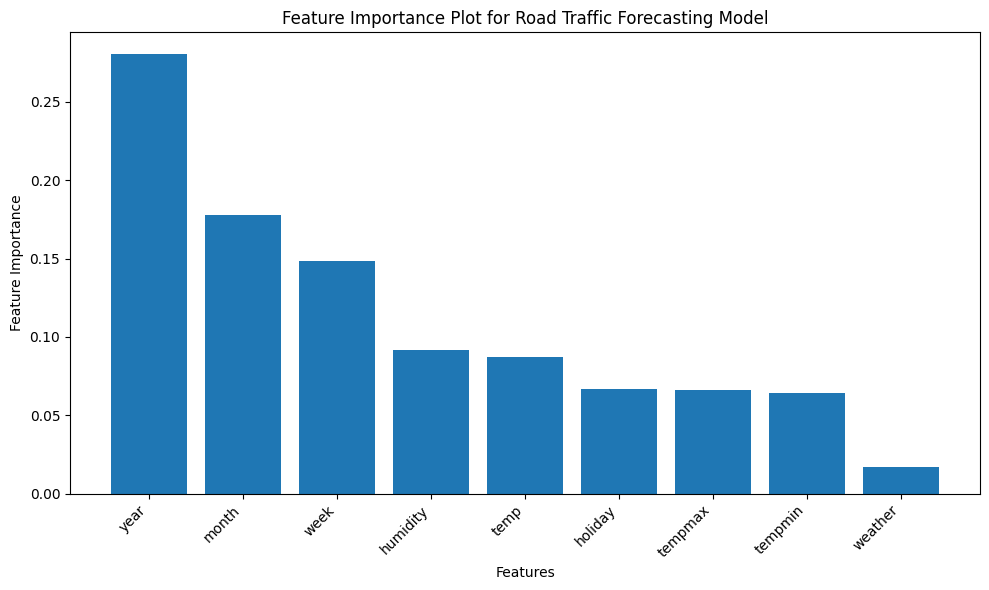

In [ ]:

X = df_curated.drop('trafficCount', axis=1)
y = df_curated['trafficCount']

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot for Road Traffic Forecasting Model')
plt.tight_layout()
plt.show()


##LSTM Model

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 70,785
Trainable params: 70,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
25/25 [==============================] - 8s 65ms/step - loss: 2.2540 - mae: 0.5586 - val_loss: 0.9595 - val_mae: 0.1513
Epoch 2/60
25/25 [==============================] - 0s 11ms/step - loss: 0.5332 - mae: 0.1567 - val_loss: 0.2621 - val_mae: 0.1426
Epoch 3/60
25/25 [==============================] - 0s 10ms/

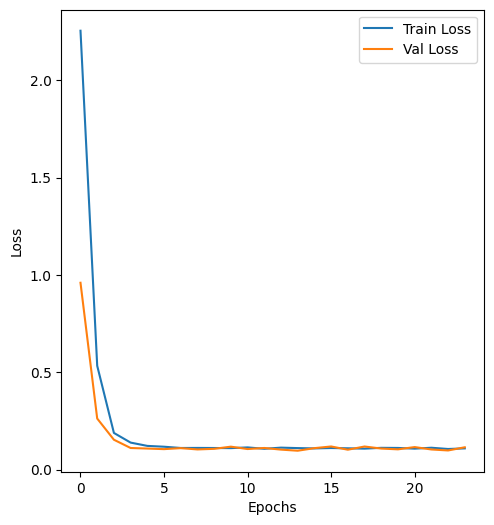

In [ ]:
# Build the LSTM model
lstm_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
], name='LSTM')

optimizer = Adam(learning_rate=0.1)

lstm_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

lstm_model.summary()

# Set up callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(path + 'model_output/lstm_best_model.h5', save_best_only=True)

# Train the model
history = lstm_model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

lstm_predictions = lstm_model.predict(X_val)

print(f"Loss: {history.history['mae'][-1]: .4f}")

In [ ]:

# Calculate MAE
mae = metrics.mean_absolute_error(y_val, lstm_predictions)

# Calculate MSE
mse = metrics.mean_squared_error(y_val, lstm_predictions)

# Calculate RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_val, lstm_predictions))

# Calculate R-squared
# r2 = metrics.r2_score(y_val, lstm_predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
# print("R-squared:", r2)

MAE: 0.08764543351093776
MSE: 0.029258224677137134
RMSE: 0.1710503571382917


In [ ]:
# Inverse transform scaled predictions to get original raw data
lstm_predictions = label_scaler.inverse_transform(lstm_predictions).flatten()
lstm_actual = label_scaler.inverse_transform(y_val).flatten()
lstm_predictions_df = pd.DataFrame({'Date': df_curated.index[-len(y_val):], 'Actual': lstm_actual, 'Predictions': lstm_predictions})

In [ ]:
# Plot predictions vs actual values
import plotly.express as px
fig = px.line(lstm_predictions_df, x='Date', y=['Actual', 'Predictions'], labels={'value': 'Traffic Count'})
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Traffic Count')
fig.update_layout(title='Actual vs Predicted Traffic Count',
                  xaxis_rangeslider_visible=True)

fig.show()

In [ ]:
lstm_predictions_df.head()

,Date,Actual,Predictions
0,2022-04-09,84334.0,80129.304688
1,2022-04-10,69632.0,69956.382812
2,2022-04-11,80836.0,80549.335938
3,2022-04-12,56595.0,62353.058594
4,2022-04-13,85968.0,84723.593750


##GRU Model

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               53376     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 53,505
Trainable params: 53,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
25/25 [==============================] - 3s 31ms/step - loss: 3.4148 - mae: 0.9873 - val_loss: 1.9785 - val_mae: 0.3007
Epoch 2/60
25/25 [==============================] - 0s 9ms/step - loss: 0.9770 - mae: 0.2345 - val_loss: 0.3553 - val_mae: 0.1452
Epoch 3/60
25/25 [==============================] - 0s 10ms/st

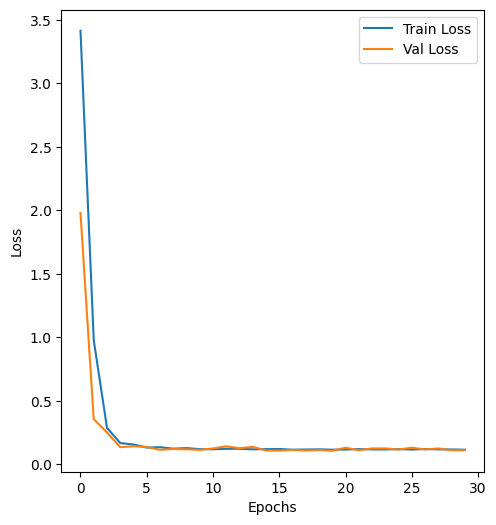

In [ ]:
# Build the GRU model
gru_model = Sequential([
    GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1)
], name='GRU')

optimizer = Adam(learning_rate=0.1)

gru_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

gru_model.summary()

# Set up callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(path + 'model_output/gru_best_model.h5', save_best_only=True)

# Train the model
history = gru_model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

gru_predictions = gru_model.predict(X_val)

print(f"Loss: {history.history['mae'][-1]: .4f}")

In [ ]:

# Calculate MAE
mae = metrics.mean_absolute_error(y_val, gru_predictions)

# Calculate MSE
mse = metrics.mean_squared_error(y_val, gru_predictions)

# Calculate RMSE
rmse = np.sqrt(metrics.mean_squared_error(y_val, gru_predictions))

# Calculate R-squared
# r2 = metrics.r2_score(y_val, gru_predictions)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
# print("R-squared:", r2)

MAE: 0.10001098433743713
MSE: 0.03139823179302032
RMSE: 0.17719546211181686


In [ ]:
# Inverse transform scaled predictions to get original raw data
gru_predictions = label_scaler.inverse_transform(gru_predictions).flatten()
gru_actual = label_scaler.inverse_transform(y_val).flatten()
gru_predictions_df = pd.DataFrame({'Date': df_curated.index[-len(y_val):], 'Actual': gru_actual, 'Predictions': gru_predictions})

In [ ]:
# Plot predictions vs actual values
import plotly.express as px
fig = px.line(gru_predictions_df, x='Date', y=['Actual', 'Predictions'], labels={'value': 'Traffic Count'})
fig.update_xaxes(title_text='Time')
fig.update_yaxes(title_text='Traffic Count')
fig.update_layout(title='Actual vs Predicted Traffic Count',
                  xaxis_rangeslider_visible=True)

fig.show()

In [ ]:
gru_predictions_df.head()

,Date,Actual,Predictions
0,2022-04-09,84334.0,77489.335938
1,2022-04-10,69632.0,79115.820312
2,2022-04-11,80836.0,82735.929688
3,2022-04-12,56595.0,64242.769531
4,2022-04-13,85968.0,82648.476562


##Comparison | LSTM ~ GRU

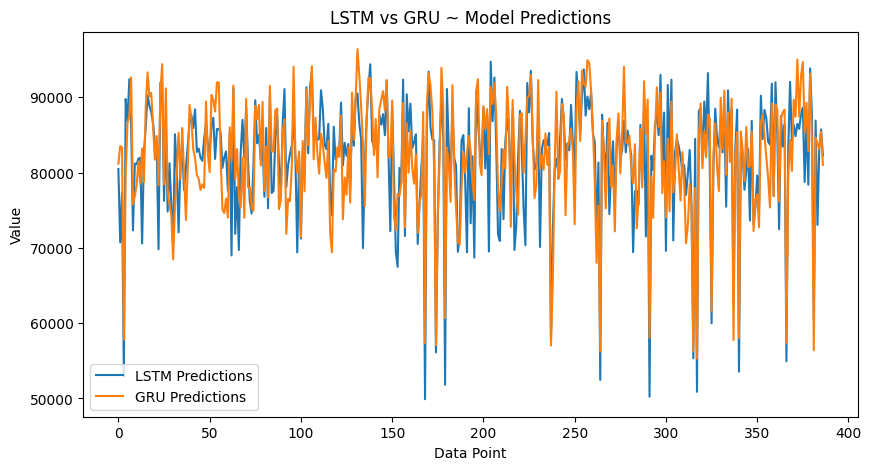

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(lstm_predictions, label='LSTM Predictions')
plt.plot(gru_predictions, label='GRU Predictions')

plt.title('LSTM vs GRU ~ Model Predictions')
plt.ylabel('Value')
plt.xlabel('Data Point')
plt.legend()

plt.show()